### Developing a phylogenetic tree for the used oligonucletide data in this work

This notebook facilitates the implementation of a phylogenetic tree using the processed sequence in this work. For this, the following steps are implemented:

- Read processed sequence in this work
- Make a query to Blast for identifying candidates for a multi alignment sequence process
- Filter candidates based on stablished criteria
- Run a multi alignment sequence
- Process the MSA and prepare data for the development of a phylogenetic tree
- Generate a phylogenetic tree
- Plot phylogenetic tree and save the results

- Process warning

In [1]:
import warnings
warnings.filterwarnings('ignore')

- Load modules

In [2]:
from Bio.Blast import NCBIWWW, NCBIXML
from Bio.Align.Applications import ClustalOmegaCommandline
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
import matplotlib.pyplot as plt
from Bio import SeqIO, Entrez, AlignIO, Phylo
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import pandas as pd
import seaborn as sns
import os
import re

- Auxiliar functions

In [3]:
def apply_process_to_name(title):

    values = title.split("|")
    names = values[-1]
    names = names.strip()
    names_list = names.split(" ")
    name_data = f"{names_list[0]} {names_list[1]}"
    return name_data

In [4]:
def get_gi(title):
    values = title.split("|")
    gi_id = f"{values[0]}|{values[1]}"
    return gi_id

In [5]:
def get_additional_id(title):
    values = title.split("|")
    additional_id = f"{values[2]}|{values[3]}"
    return additional_id

In [6]:
def check_entres_to_ignore(title):
    if "PREDICTED" in title or "cultured" in title or "Cloning" in title or "Synthetic construct" in title or "Homo sapiens" in title:
        return True
    else:
        return False

In [7]:
def recover_full_sequence(title):
    
    try:
        Entrez.email = "david.medina@cebib.cl"

        accession = re.search(r"\|([A-Z_]+\d+\.\d+)\|", title)
        if accession:
            acc = accession.group(1)

            # Descargar la secuencia completa
            handle = Entrez.efetch(db="nucleotide", id=acc, rettype="fasta", retmode="text")
            record = SeqIO.read(handle, "fasta")
            return str(record.seq)
        else:
            return "seq not found"
    except:
        return "seq not found"

- Load input sequence

In [8]:
for record in SeqIO.parse("../raw_data/oligos_sequences.fasta", "fasta"):
    sequences_to_process = {
        "Organism" : record.description,
        "Sequence" : str(record.seq)
    }

sequences_to_process

{'Organism': 'Study Argopecten purpuratus',
 'Sequence': 'TCAGTTCAACAGTGTTTGGGCATGAGTCTCTACAATGTACTGGTGGTATTGTTTTAGCAGGTGATGCATTTGTTCTACTTCTTCACTGACTAGTGTTTTCACAAAGAATTTCTTATCCTGAGACATCAACATCCGGGCCCCACTCCGGCCGGGGGAGTCTACATCCAACGCCTGCTTAGTTAAGGAGTTCATATAATCTTGGTCATCGATTCCGAATCTCTCCCGGAGATTCCTGAACACAACTGGGCAATACTCCTTACCTTGAAATGACTTGGCATACTTTCTTTGTTGTAAGAATGATTGTCCACTCGTACTTTACTGAACGCTTTAAAATCATCGGGCATCAACATTACAGGAAGGTTCACATGGTTCAAGCCATTTATCGTATGATTAATCCCCCACCAATGACATCTAGAGAATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATGGGAGAGCTCCCAACGCGTTGGATGCATA'}

- Making query to NCBI-BLAST for alignment sequences

In [38]:
query_seq = Seq(sequences_to_process["Sequence"])
record = SeqRecord(query_seq, id="Query1", description=sequences_to_process["Organism"])

print("Sending BLAST query to NCBI...")
result_handle = NCBIWWW.qblast(
    program="blastn",             
    database="nt",                
    sequence=record.format("fasta"),
    hitlist_size=10000,              
    format_type="XML",
    entrez_query="marine[All Fields] AND COI[Gene]"
)

blast_records = NCBIXML.read(result_handle)

filter_sequences = []

for alignment in blast_records.alignments:
    hsp = alignment.hsps[0]  # high-scoring pair
    
    row = [
        alignment.title,
        hsp.score,
        hsp.sbjct,
        hsp.identities / hsp.align_length
    ]

    filter_sequences.append(row)

df_selected_sequences = pd.DataFrame(
    data=filter_sequences, 
    columns=["title", "score", "aligned_sequence", "identity"])

df_selected_sequences.head(5)

Sending BLAST query to NCBI...


,title,score,aligned_sequence,identity
0,gi|1774220794|gb|MK896701.1| Dinophilus vortic...,36.0,TGTTTTAGCAGG---TGCAATTACTATACTTC-TCACTGAC,0.804878
1,gi|380508830|ref|NC_006886.2| Mytilus gallopro...,36.0,ATGGTTCAAGCCATTTAT,1.000000


In [12]:
df_selected_sequences.shape

(130, 4)

- Removing PREDICTED/Uncultured elements

In [13]:
df_selected_sequences["to_ignore"] = df_selected_sequences["title"].apply(check_entres_to_ignore)
df_selected_sequences["to_ignore"].value_counts()
df_filter_sequences = df_selected_sequences[df_selected_sequences["to_ignore"]==False]
df_filter_sequences.head(5)

,title,score,aligned_sequence,identity,to_ignore
1,gi|2671790432|gb|PP199098.1| Argopecten irradi...,267.0,CTGGTGGTATTGTTTAAGCAGGTGATGCATCTGTTCTACTTCTTCA...,0.953642,False
2,gi|2277725323|gb|MW800702.1| Octopus vulgaris ...,214.0,AACAACGTCTGTGCGTGTCTTTCAACAATATATGAGTGATACTGTT...,0.717500,False
12,gi|198033776|emb|AM883195.1| endosymbiont of S...,140.0,AATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATGGGAG...,1.000000,False
21,gi|198033772|emb|AM883193.1| endosymbiont of O...,140.0,AATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATGGGAG...,1.000000,False
50,gi|198033774|emb|AM883194.1| endosymbiont of O...,140.0,AATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATGGGAG...,1.000000,False


In [14]:
df_filter_sequences.shape

(45, 5)

- Get names and IDs

In [15]:
df_filter_sequences["organism"] = df_filter_sequences["title"].apply(apply_process_to_name)
df_filter_sequences["gi"] = df_filter_sequences["title"].apply(get_gi)
df_filter_sequences["additionl_id"] = df_filter_sequences["title"].apply(get_additional_id)
df_filter_sequences.head(5)

,title,score,aligned_sequence,identity,to_ignore,organism,gi,additionl_id
1,gi|2671790432|gb|PP199098.1| Argopecten irradi...,267.0,CTGGTGGTATTGTTTAAGCAGGTGATGCATCTGTTCTACTTCTTCA...,0.953642,False,Argopecten irradians,gi|2671790432,gb|PP199098.1
2,gi|2277725323|gb|MW800702.1| Octopus vulgaris ...,214.0,AACAACGTCTGTGCGTGTCTTTCAACAATATATGAGTGATACTGTT...,0.717500,False,Octopus vulgaris,gi|2277725323,gb|MW800702.1
12,gi|198033776|emb|AM883195.1| endosymbiont of S...,140.0,AATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATGGGAG...,1.000000,False,endosymbiont of,gi|198033776,emb|AM883195.1
21,gi|198033772|emb|AM883193.1| endosymbiont of O...,140.0,AATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATGGGAG...,1.000000,False,endosymbiont of,gi|198033772,emb|AM883193.1
50,gi|198033774|emb|AM883194.1| endosymbiont of O...,140.0,AATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATGGGAG...,1.000000,False,endosymbiont of,gi|198033774,emb|AM883194.1


In [16]:
df_filter_sequences["organism"].value_counts()

Vibrio harveyi                  6
endosymbiont of                 3
Symbiodinium sp.                2
Halomonas sp.                   2
Pseudomonas sp.                 2
Arthrobacter sp.                2
Aeromicrobium sp.               1
Metabacillus sediminis          1
MAG: Candidatus                 1
Cherax quadricarinatus          1
Vibrio sp.                      1
Catalinimonas niigatensis       1
MAG: Gemmatimonadetes           1
Spongiibacter nanhainus         1
Alcanivorax borkumensis         1
Bacillus sp.                    1
Variovorax sp.                  1
Pelagibacterium halotolerans    1
Cynoglossus semilaevis          1
Argopecten irradians            1
Pomacentrus amboinensis         1
Octopus vulgaris                1
Lithognathus mormyrus           1
Aurantiochytrium sp.            1
Pichia fermentans               1
Aurantimonas sp.                1
Nematostella vectensis          1
Thraustochytriidae sp.          1
Hyphomicrobium sp.              1
Janthinobacter

- Checking duplicated entries. Including organisms and sequences

In [17]:
name_cound = df_filter_sequences.groupby(by="organism").count().sort_values(by="title", ascending=False)
unique_names = name_cound[name_cound["title"]==1]
duplicated_names = name_cound[name_cound["title"]>1]

print(unique_names.shape, duplicated_names.shape)

(28, 7) (6, 7)


In [18]:
filter_unique_names = df_filter_sequences[df_filter_sequences["organism"].isin(unique_names.index)]
filter_unique_names.shape

(28, 8)

In [19]:
filter_unique_names.columns

Index(['title', 'score', 'aligned_sequence', 'identity', 'to_ignore',
       'organism', 'gi', 'additionl_id'],
      dtype='object')

In [20]:
matrix_duplicated = []
for organism in duplicated_names.index:
    records_in_df = df_filter_sequences[df_filter_sequences["organism"] == organism]
    records_in_df.reset_index(inplace=True)
        
    row = []

    for column in ['title', 'score', 'aligned_sequence', 'identity', 'to_ignore', 'organism', 'gi', 'additionl_id']:
        row.append(records_in_df[column][0])
    
    matrix_duplicated.append(row)

df_selected_duplicated = pd.DataFrame(data=matrix_duplicated, columns=filter_unique_names.columns)
df_selected_duplicated

,title,score,aligned_sequence,identity,to_ignore,organism,gi,additionl_id
0,gi|729057370|gb|CP009467.2| Vibrio harveyi str...,44.0,AGGAATTCATAAGAATCTTGGTCATCGATGCCGA,0.882353,False,Vibrio harveyi,gi|729057370,gb|CP009467.2
1,gi|198033776|emb|AM883195.1| endosymbiont of S...,140.0,AATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATGGGAG...,1.000000,False,endosymbiont of,gi|198033776,emb|AM883195.1
2,gi|34525829|emb|AJ551115.1| Halomonas sp. mp1 ...,107.0,AATCACTAGTG------CGGCCGCCTGCAGGTCGACCATATGGGAG...,0.911765,False,Halomonas sp.,gi|34525829,emb|AJ551115.1
3,gi|34525865|emb|AJ551151.1| Arthrobacter sp. A...,99.0,AATCACTAGTG------CGGCCGCCTGCAGGTCGACCATATGGGAG...,0.906250,False,Arthrobacter sp.,gi|34525865,emb|AJ551151.1
4,gi|77362710|dbj|AB207195.1| Symbiodinium sp. A...,61.0,GAATCACTAGTG------CGGCCGCCTGCAGGTCGACCATATGGG,0.866667,False,Symbiodinium sp.,gi|77362710,dbj|AB207195.1
5,gi|34525856|emb|AJ551142.1| Pseudomonas sp. An...,99.0,AATCACTAGTG------CGGCCGCCTGCAGGTCGACCATATGGGAG...,0.906250,False,Pseudomonas sp.,gi|34525856,emb|AJ551142.1


In [21]:
processed_df = pd.concat([filter_unique_names, df_selected_duplicated], axis=0)
processed_df.reset_index(inplace=True)
processed_df = processed_df.drop(columns=["index"])
processed_df.shape

(34, 8)

- Get full sequences

In [23]:
processed_df["full_sequence"] = processed_df["title"].apply(recover_full_sequence)

In [24]:
processed_df = processed_df[processed_df["full_sequence"] != "seq not found"]
processed_df.shape

(34, 9)

In [25]:
processed_df.head(5)

,title,score,aligned_sequence,identity,to_ignore,organism,gi,additionl_id,full_sequence
0,gi|2671790432|gb|PP199098.1| Argopecten irradi...,267.0,CTGGTGGTATTGTTTAAGCAGGTGATGCATCTGTTCTACTTCTTCA...,0.953642,False,Argopecten irradians,gi|2671790432,gb|PP199098.1,CCATCTTGGATGTTGAGAGGTGTTGCAGCGATAATGGACCGTCTAC...
1,gi|2277725323|gb|MW800702.1| Octopus vulgaris ...,214.0,AACAACGTCTGTGCGTGTCTTTCAACAATATATGAGTGATACTGTT...,0.717500,False,Octopus vulgaris,gi|2277725323,gb|MW800702.1,ATGGCTAGTGCCAAAAGGAAGCACCTTAAAATGAAAACTGTCCAAC...
2,gi|34525880|emb|AJ551166.1| Rhodococcus sp. An...,111.0,AATCACTAGTG------CGGCCGCCTGCAGGTCGACCATATGGGAG...,0.914286,False,Rhodococcus sp.,gi|34525880,emb|AJ551166.1,GTCGCATGCTCCCGGCCGCCATGGCCGCGGGATTGGTTACCTTGTT...
3,gi|170676012|dbj|AB305628.1| Haplochromis chil...,108.0,AATCACTAGTGAAT-CGCGGCCGCCTGCAGGTCGACCATATGGGAG...,0.942857,False,Haplochromis chilotes,gi|170676012,dbj|AB305628.1,GATCTCAGTTTATAGAGATTAATAGCTGTCCACCTCGTAGAAATTA...
4,gi|329581600|emb|FR750934.1| Cobetia marina pa...,107.0,AATCACTAGTG------CGGCCGCCTGCAGGTCGACCATATGGGAG...,0.911765,False,Cobetia marina,gi|329581600,emb|FR750934.1,CATGCAAGTCGAGCGGAACGATCCTAGCTTGCTAGGAGGCGTCGAG...


- Checking length

In [26]:
processed_df["length"] = processed_df["full_sequence"].str.len()
processed_df["length"].describe()

count    3.400000e+01
mean     1.567519e+06
std      2.283889e+06
min      4.730000e+02
25%      8.072500e+02
50%      1.600000e+03
75%      3.752318e+06
max      7.168845e+06
Name: length, dtype: float64

- Checking identity distribution

<Axes: xlabel='identity', ylabel='Count'>

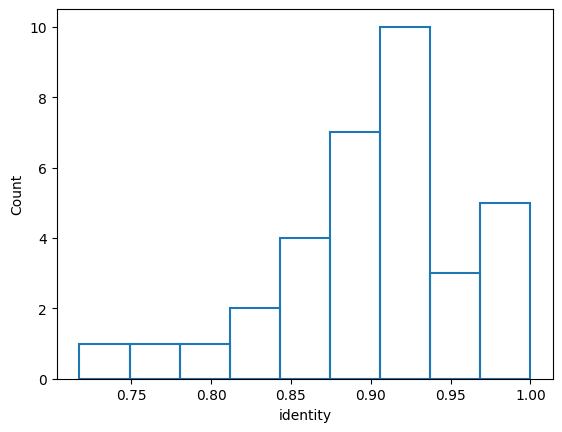

In [28]:
sns.histplot(data=processed_df, x="identity", fill=False)

<Axes: xlabel='identity'>

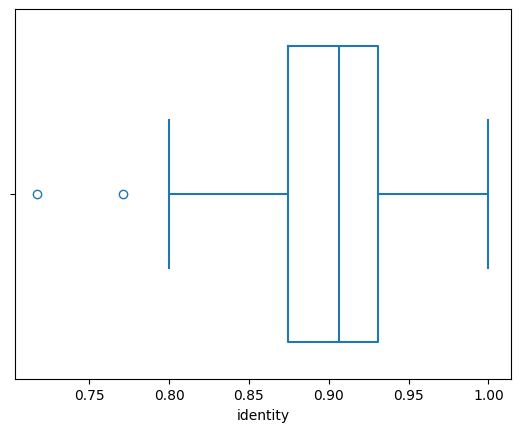

In [29]:
sns.boxplot(data=processed_df, x="identity", fill=False)

In [30]:
processed_df.describe()

,score,identity,length
count,34.000000,34.000000,3.400000e+01
mean,79.088235,0.901412,1.567519e+06
std,49.246054,0.064673,2.283889e+06
min,44.000000,0.717500,4.730000e+02
25%,45.000000,0.874434,8.072500e+02
50%,63.000000,0.906250,1.600000e+03
75%,99.000000,0.931034,3.752318e+06
max,267.000000,1.000000,7.168845e+06


In [33]:
processed_df["is_for_tree"] = (processed_df["identity"]>=0.70).astype(int)
processed_df["is_for_tree"].value_counts()

1    34
Name: is_for_tree, dtype: int64

In [34]:
df_for_tree = processed_df[processed_df["is_for_tree"]==1]
df_for_tree.shape

(34, 11)

In [35]:
df_for_tree.head(5)

,title,score,aligned_sequence,identity,to_ignore,organism,gi,additionl_id,full_sequence,length,is_for_tree
0,gi|2671790432|gb|PP199098.1| Argopecten irradi...,267.0,CTGGTGGTATTGTTTAAGCAGGTGATGCATCTGTTCTACTTCTTCA...,0.953642,False,Argopecten irradians,gi|2671790432,gb|PP199098.1,CCATCTTGGATGTTGAGAGGTGTTGCAGCGATAATGGACCGTCTAC...,10545,1
1,gi|2277725323|gb|MW800702.1| Octopus vulgaris ...,214.0,AACAACGTCTGTGCGTGTCTTTCAACAATATATGAGTGATACTGTT...,0.717500,False,Octopus vulgaris,gi|2277725323,gb|MW800702.1,ATGGCTAGTGCCAAAAGGAAGCACCTTAAAATGAAAACTGTCCAAC...,1230,1
2,gi|34525880|emb|AJ551166.1| Rhodococcus sp. An...,111.0,AATCACTAGTG------CGGCCGCCTGCAGGTCGACCATATGGGAG...,0.914286,False,Rhodococcus sp.,gi|34525880,emb|AJ551166.1,GTCGCATGCTCCCGGCCGCCATGGCCGCGGGATTGGTTACCTTGTT...,1582,1
3,gi|170676012|dbj|AB305628.1| Haplochromis chil...,108.0,AATCACTAGTGAAT-CGCGGCCGCCTGCAGGTCGACCATATGGGAG...,0.942857,False,Haplochromis chilotes,gi|170676012,dbj|AB305628.1,GATCTCAGTTTATAGAGATTAATAGCTGTCCACCTCGTAGAAATTA...,859,1
4,gi|329581600|emb|FR750934.1| Cobetia marina pa...,107.0,AATCACTAGTG------CGGCCGCCTGCAGGTCGACCATATGGGAG...,0.911765,False,Cobetia marina,gi|329581600,emb|FR750934.1,CATGCAAGTCGAGCGGAACGATCCTAGCTTGCTAGGAGGCGTCGAG...,1519,1


- Prepare a fasta file for generating the MSA

In [36]:
fasta_file = "tmp.fasta"
records = [
    SeqRecord(Seq(seq), id=seq_id, description="")
    for seq_id, seq in zip(df_for_tree["organism"], df_for_tree["full_sequence"])
]

record_seq = SeqRecord(query_seq, id="Argopecten purpuratus", description="")

records.append(record_seq)

SeqIO.write(records, fasta_file, "fasta")

35

- Runing MSA

In [ ]:
aligned_file = "aligned_sequences.fasta"
clustalomega_cline = ClustalOmegaCommandline(
    infile=fasta_file, outfile=aligned_file, verbose=True, auto=True, force=True
)
print("Running alignment...")
stdout, stderr = clustalomega_cline()